# Boston Housing 

    Prevendo valores de moradias nos subúrbios de Boston com Regressão Linear  

https://www.kaggle.com/datasets/schirmerchad/bostonhoustingmlnd

### Contexto 

O conjunto de dados para este projeto é originário do UCI Machine Learning Repository. Os dados habitacionais de Boston foram coletados em 1978 e cada uma das 506 entradas representa dados agregados sobre 14 características de residências de vários subúrbios de Boston, Massachusetts.

Este dataset modificado consiste em 489 entradas com 4 colunas, sendo 3 variáveis explicativas e 1 variável resposta.

### Conteúdo

*Features*
* RM: número médio de quartos por habitação
* LSTAT: porcentagem da população considerada de status inferior
* PTRATIO: relação aluno-professor por município

*Target*
* MEDV: valor médio de casas ocupadas pelos proprietários

In [1]:
# Importação das bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Como importar dataset local do Kaggle
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bostonhoustingmlnd/housing.csv


In [3]:
# Importando dataset 
boston = pd.read_csv('/kaggle/input/bostonhoustingmlnd/housing.csv')
boston

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0
...,...,...,...,...
484,6.593,9.67,21.0,470400.0
485,6.120,9.08,21.0,432600.0
486,6.976,5.64,21.0,501900.0
487,6.794,6.48,21.0,462000.0


## Análise Exploratória

Inicialmente gerar as entradas e saídas do dataframe para ter conhecimento sobre como os dados estão estruturados.

In [4]:
boston.info()
boston.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   RM       489 non-null    float64
 1   LSTAT    489 non-null    float64
 2   PTRATIO  489 non-null    float64
 3   MEDV     489 non-null    float64
dtypes: float64(4)
memory usage: 15.4 KB


,RM,LSTAT,PTRATIO,MEDV
count,489.000000,489.000000,489.000000,4.890000e+02
mean,6.240288,12.939632,18.516564,4.543429e+05
std,0.643650,7.081990,2.111268,1.653403e+05
min,3.561000,1.980000,12.600000,1.050000e+05
25%,5.880000,7.370000,17.400000,3.507000e+05
50%,6.185000,11.690000,19.100000,4.389000e+05
75%,6.575000,17.120000,20.200000,5.187000e+05
max,8.398000,37.970000,22.000000,1.024800e+06


O método **.info()** retorna um resumo conciso do dataframe, permitindo identificar o tipo da variável em cada coluna. Já o método **.describe()** retorna diferentes características das colunas numéricas do dataframe (distribuições estatísticas).

Aqui já podemos observar que não há missing values e aparentemente não há muitos valores destoantes no conjunto de dados, porém podemos confirmar com os métodos .isnull() e gráfico boxplot. 

In [5]:
boston.isnull().sum()

RM         0
LSTAT      0
PTRATIO    0
MEDV       0
dtype: int64

<AxesSubplot:>

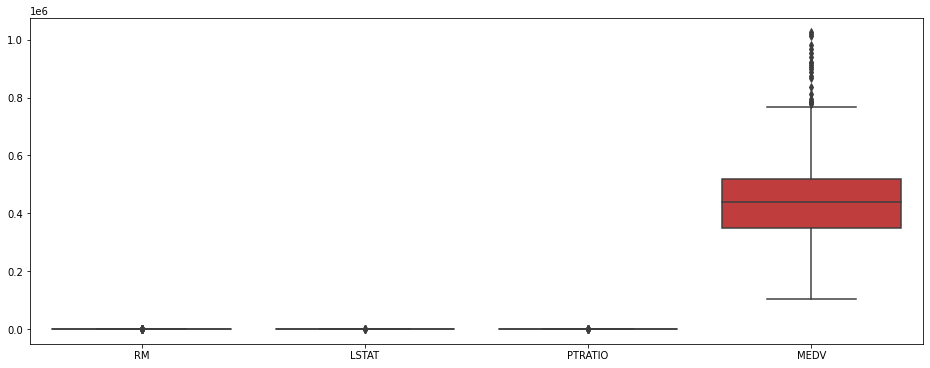

In [6]:
plt.figure(figsize = (16,6))
sns.boxplot(data = boston)

Confirmamos que não há missing values no dataset, porém outliers há alguns, mas nada que precise ser tratado e altere a análise dos dados. 

#### Distribuição da variável target 

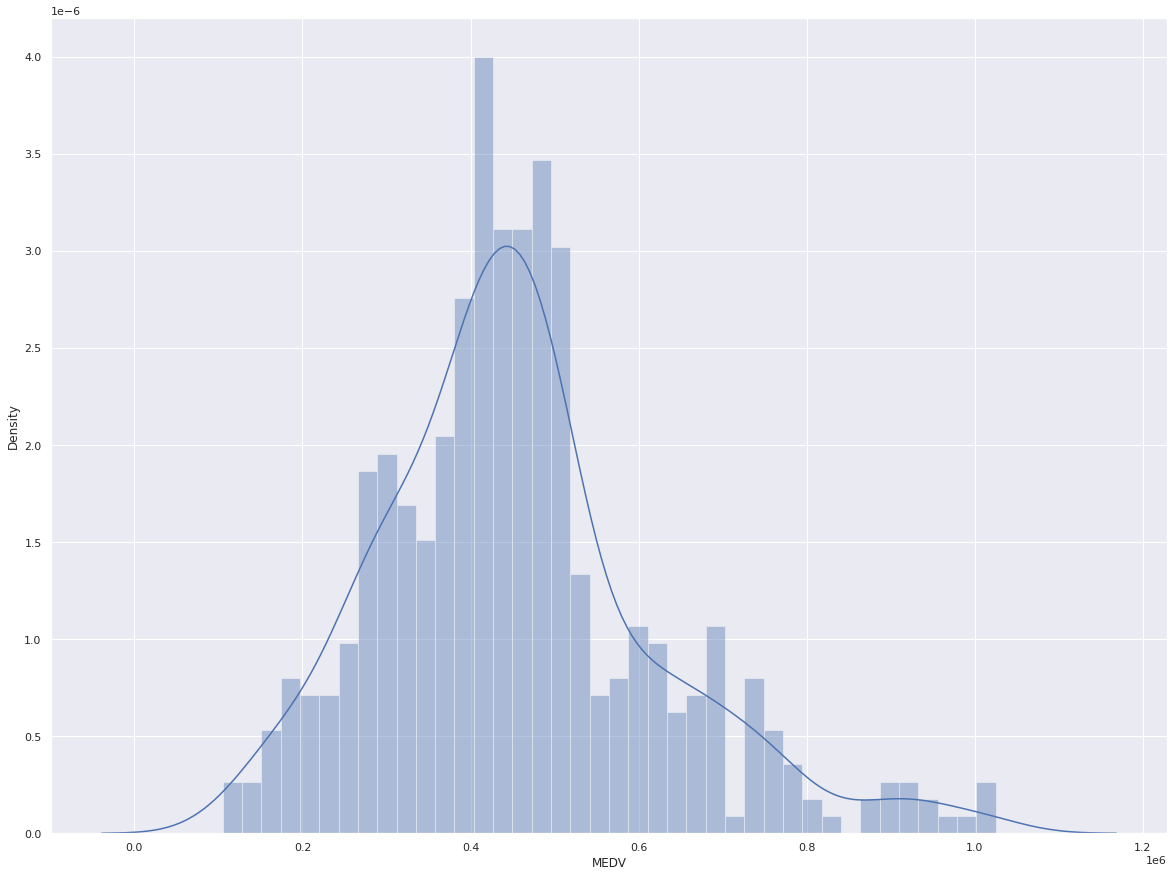

In [7]:
sns.set(rc={'figure.figsize':(20, 15)})
sns.distplot(boston['MEDV'], bins=40)
plt.show()

In [8]:
print(boston['MEDV'].quantile([.1, .25, .5, .75, .99]))

0.10    266700.0
0.25    350700.0
0.50    438900.0
0.75    518700.0
0.99    954912.0
Name: MEDV, dtype: float64


O gráfico mostra como os valores destoantes que observamos anteriormente no boxplot estão distribuídos em relação aos outros valores. 

#### Correlação entre as features e o target 

Através do heatmap, podemos entender a correlação entre as variáveis explicativas e o target ('MEDV'), sendo elas positivas ou negativas

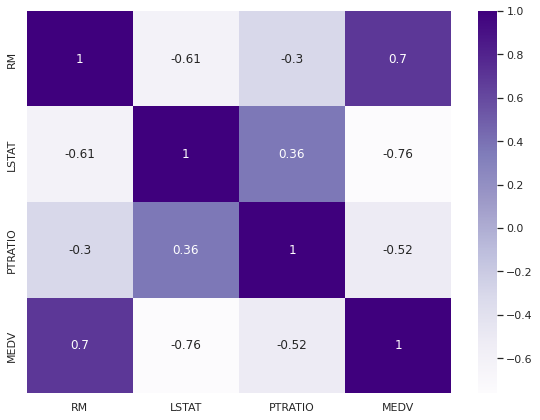

In [9]:
fig, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(boston.corr(), fmt = '.2g', cmap = 'Purples', annot= True)
# annot é True para imprimeir os valores dentro do quadrado
plt.tight_layout()

As maiores correalações, seja positiva ou negativa, apresentadas foram entre a variável RM e MEDV (target), cujo valor é de 0,7, e entre as as variávels RM e LSTAT com valor de -0,76.

Para ajustar um **modelo de Regressão Linear**, os recursos que têm alta correlação com nossa variável target são os melhores a serem selecionados. Um ponto importante na seleção de recursos para um modelo RL é verificar a **multicolinearidade**, ou seja, variáveis que são fortemente correlacionadas entre si (por exemplo, com correlação acima de 0,9). Quando ocorre isso, não devemos selecionar essas variáveis de forma conjunta para treinar o modelo. 

Neste caso, iremos selecionar as features com maior correlação (RM e LSTAT), pois acredito que a variável PTRATIO não irá agregar ao modelo em questão,porém se deixássemos talvez não teria tanta alteração. Em casos que há muitas features, a escolha certa delas implica mais no sucesso do modelo.

In [10]:
# Excluíndo a variável PTRATIO
new_boston = boston.drop(columns=['PTRATIO'])
new_boston.head()

,RM,LSTAT,MEDV
0,6.575,4.98,504000.0
1,6.421,9.14,453600.0
2,7.185,4.03,728700.0
3,6.998,2.94,701400.0
4,7.147,5.33,760200.0


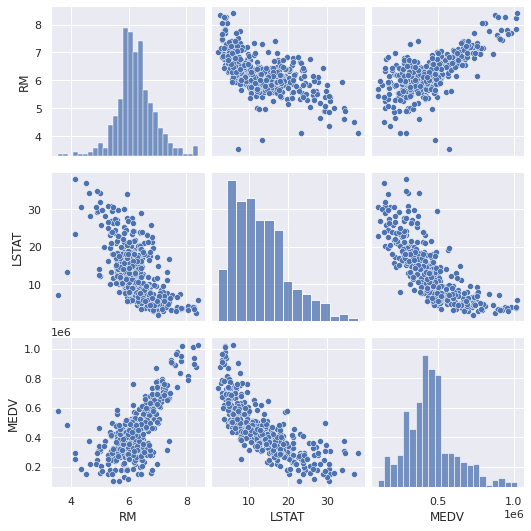

In [11]:
# Gráficos de dispersão para vermos como as features e target se comportam 
sns.pairplot(new_boston)

Podemos tirar algumas conclusões:

* O preço aumenta à medida que o valor de RM aumenta linearmente. Existem poucos outliers e os dados parecem estar limitados a 50. 

* Os preços tendem a diminuir com o aumento do LSTAT. Embora não pareça seguir exatamente uma linha linear. 

* E podemos observar de forma linear que quanto menor o LSTAT maior é o RM.

## Modelo de Machine Learning

A **Regressão Linear** pode ser definida como uma equação que visa estimar o valor esperado de uma variável y, dados alguns valores de outras variáveis x. A mesma considera que as relações existentes entre as variáveis dependentes e as de entradas são lineares, do tipo y = mx + b. Neste caso, o valor de y é o que queremos prever, m é um coeficiente angular, x é o valor de uma dada coluna, e b* é uma constante.

É um **modelo preditivo** usado para modelar a relação linear entre a variável target contínua e variáveis preditoras que podem ser contínuas ou categóricas.

Para avaliarmos a qualidade do modelo, podemos usar as medidas de **R²**, que irá nos dizer quantos porcentos da variação dos dados pode ser explicada pelas variáveis preditoras.

Outra medida de ajuste presente é o **RMSE** (root mean squared error) que é a medida que calcula "a raiz quadrática média" dos erros entre valores observados (reais) e predições (hipóteses). 

Uma característica do RMSE é que os erros (reais - predições) são elevados ao quadrado antes de ter a média calculada. Portanto, pesos diferentes serão atribuídos à soma e, conforme os valores de erros das instâncias aumentam o índice do RMSE aumenta consideravelmente. Ou seja, se houver um outlier no conjunto de dados, seu peso será maior para o cálculo do RMSE e, por conseguinte, prejudicará sua métrica deixando-a maior.

#### Divisão do conjunto de dados 

Por nesse caso se tratar de apenas um dataset para aplicar o modelo de machine learning, se faz necessário dividir uma porcentagem em treino e outra porcentagem menor em teste. 

Antes disso, devemos dividir nosso dataset em X e Y, sendo X contendo apenas as features e Y contendo a variável target. 

In [12]:
X = new_boston.iloc[:,0:2]
Y = new_boston.iloc[:,2]

In [13]:
# Dataset apenas com features
X

,RM,LSTAT
0,6.575,4.98
1,6.421,9.14
2,7.185,4.03
3,6.998,2.94
4,7.147,5.33
...,...,...
484,6.593,9.67
485,6.120,9.08
486,6.976,5.64
487,6.794,6.48


In [14]:
# Dataset apenas com target
Y

0      504000.0
1      453600.0
2      728700.0
3      701400.0
4      760200.0
         ...   
484    470400.0
485    432600.0
486    501900.0
487    462000.0
488    249900.0
Name: MEDV, Length: 489, dtype: float64

In [15]:
# Biblioteca para separar o conjunto de dados
from sklearn.model_selection import train_test_split

# Separando o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

In [16]:
# Como ficou a quantidade na divisão de treino
print(X_train.shape)
print(y_train.shape)

(391, 2)
(391,)


In [17]:
# Como ficou a quantidade na divisão de teste
print(X_test.shape)
print(y_test.shape)

(98, 2)
(98,)


## Regressão Linear 

In [18]:
# Importando bibliotecas da Regressão Linear e suas métricas
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [19]:
# Instanciando o modelo 
lr = LinearRegression ()

# Treinando o modelo
lr.fit(X_train, y_train)

LinearRegression()

In [20]:
# Predição do modelo de treino
y_train_lr_predict = lr.predict(X_train)

# Prediçaõ do modelo de teste 
y_test_lr_predict = lr.predict(X_test)

#### Avaliação do modelo no conjunto de treino

In [21]:
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_lr_predict))
r2_train = r2_score(y_train, y_train_lr_predict)

print("Desempenho do modelo de RL para conjunto de treino")
print("---------------------------------------------------")
print("RMSE do conjunto de teste é {}".format(rmse_train))
print("R2 Score do conjunto de teste é {}".format(r2_train))

Desempenho do modelo de RL para conjunto de treino
---------------------------------------------------
RMSE do conjunto de teste é 99404.70807449461
R2 Score do conjunto de teste é 0.6609362318891483


#### Avaliando o modelo no conjunto de teste 

In [22]:
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_lr_predict))
r2_test = r2_score(y_test, y_test_lr_predict)

print("Desempenho do modelo de RL para conjunto de treino")
print("---------------------------------------------------")
print("RMSE do conjunto de teste é {}".format(rmse_test))
print("R2 Score do conjunto de teste é {}".format(r2_test))

Desempenho do modelo de RL para conjunto de treino
---------------------------------------------------
RMSE do conjunto de teste é 79632.34440216917
R2 Score do conjunto de teste é 0.6805688443016455


#### Comparação entre os valores de teste e os valores previstos da variável target 

In [23]:
# Valores atuais no dataset e valores previstos 
lr_compare = pd.DataFrame({'Atual': y_test, 'Predito': y_test_lr_predict})
print(lr_compare)

        Atual        Predito
172  487200.0  472367.908147
107  428400.0  433158.534592
208  525000.0  495321.185364
212  483000.0  500345.457275
314  516600.0  572666.141073
..        ...            ...
114  388500.0  489907.807527
447  449400.0  451520.114584
227  504000.0  468990.454770
184  732900.0  638884.550610
260  443100.0  421443.207231

[98 rows x 2 columns]


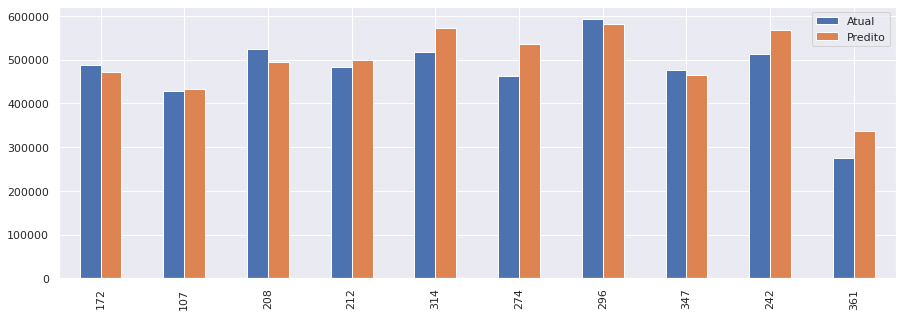

In [24]:
# Gráfico comparativo entre os valores 
(lr_compare.head(10)).plot(kind='bar', figsize=(15,5))
plt.show()

Podemos observar que a variância entre os valores atuais e os valores previstos em alguns casos está mais divergente que outros, mas em maioria a predição foi bem próxima. 

Sendo assim, podemos considerar que **o modelo de Regressão Linear teve um bom resultado para o dataset em questão**. 